In [1]:
#Importamos Librerias Necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, learning_curve
from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_squared_log_error
from math import sqrt

In [2]:
#Cargar la función para llegar a los CSV divididos
def load_split(seed):
    X_train = pd.read_csv(f'X_train_{seed}.csv')
    X_test = pd.read_csv(f'X_test_{seed}.csv')
    y_train = pd.read_csv(f'y_train_{seed}.csv')
    y_test = pd.read_csv(f'y_test_{seed}.csv')
    
    return X_train, X_test, y_train, y_test

Cross-validated MSE: 0.4203208790873467
Fitting 10 folds for each of 27 candidates, totalling 270 fits
Best parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300}


C:\Users\HP\AppData\Local\Temp\ipykernel_11284\3007541896.py:80: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importances, palette=colores)


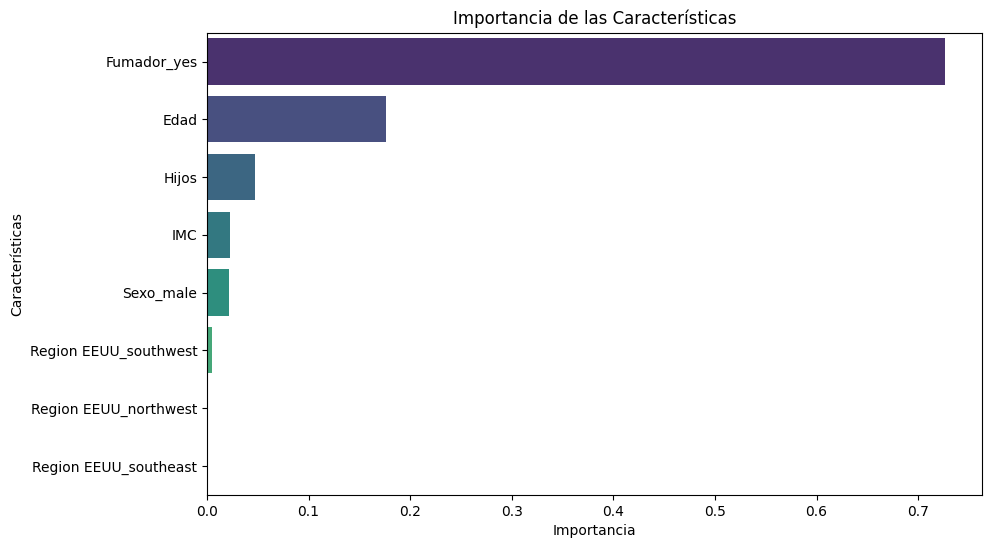

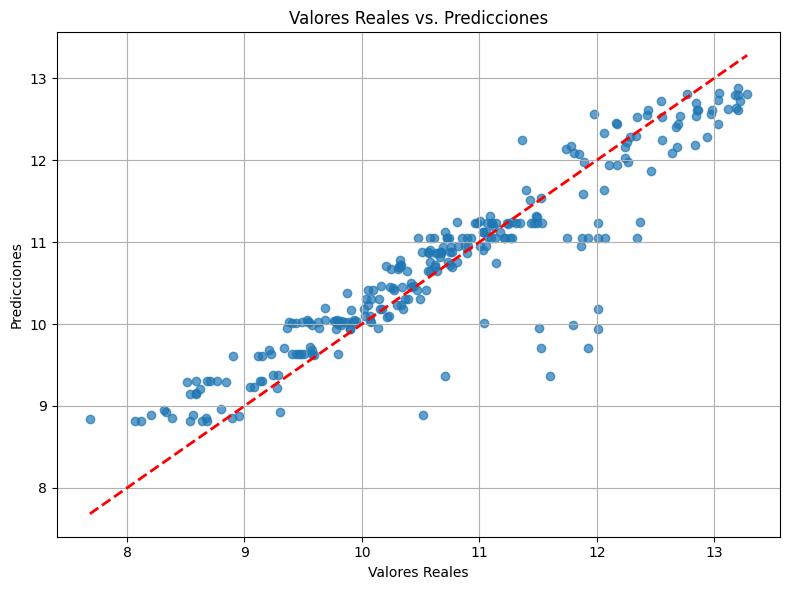

MAE: 0.3418149719669099
MSE: 0.25103667469123064
RMSE: 0.5010356022192741
R2 Score: 0.8429772459732938
RMSLE: 0.04362873964852581
MAPE: 3.2233839417150154


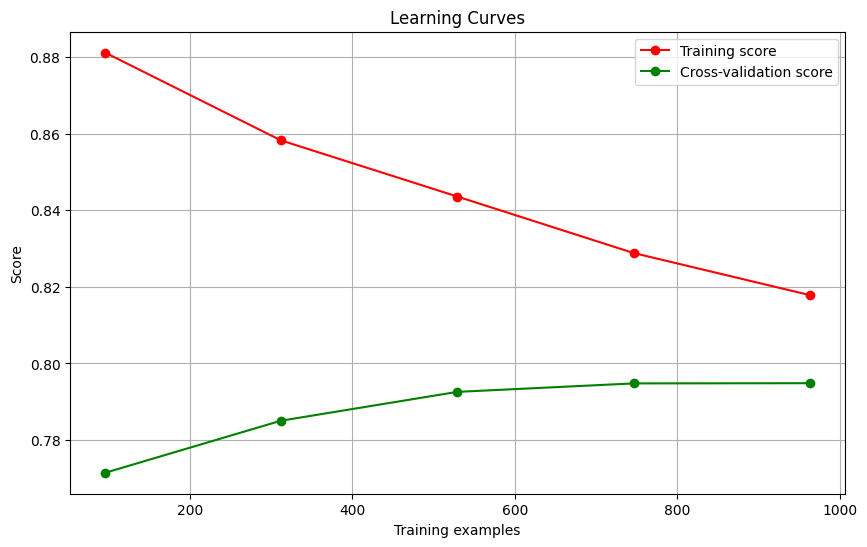

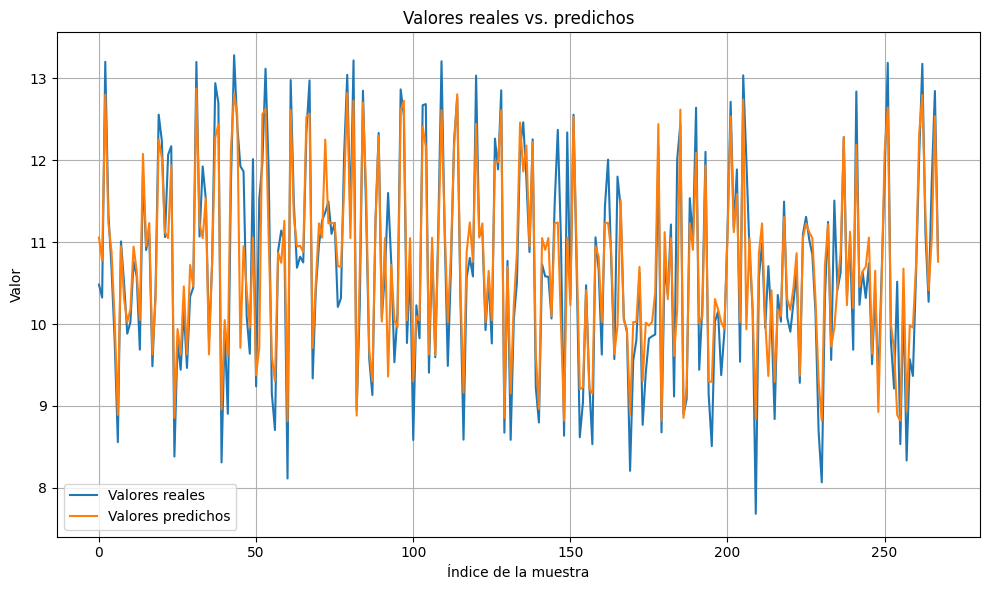

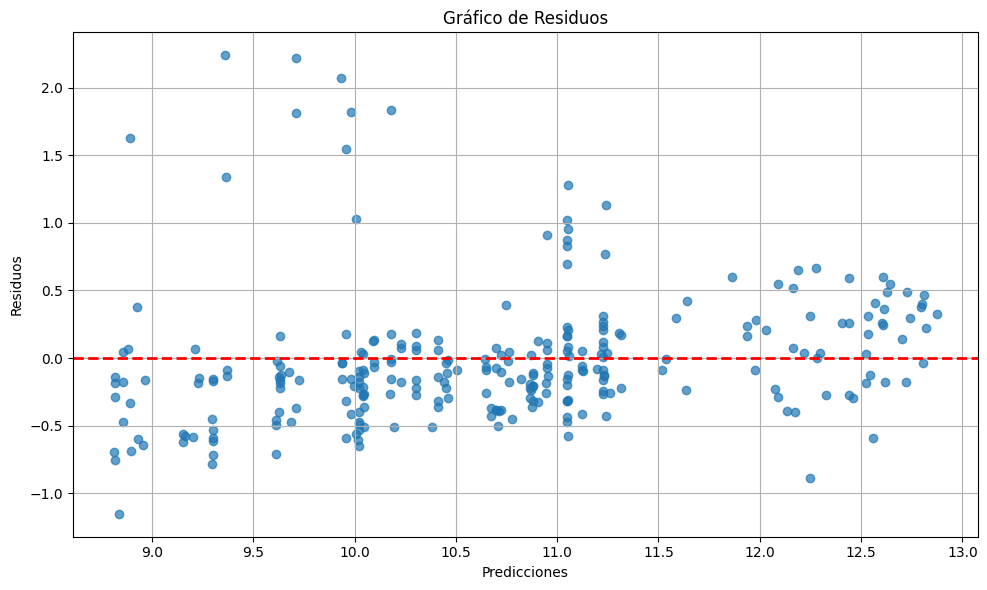

In [3]:
# Cargar una división específica (por ejemplo, la primera división)
X_train, X_test, y_train, y_test = load_split(0)

# Convertir y_train e y_test a series de pandas para asegurar que no haya problemas de tipo
y_train = y_train.squeeze().astype(float)
y_test = y_test.squeeze().astype(float)

# Verificar que y_train e y_test son de tipo float
assert y_train.dtype == float, f"y_train is not float but {y_train.dtype}"
assert y_test.dtype == float, f"y_test is not float but {y_test.dtype}"

# Aplicar One-Hot Encoding a las variables categóricas
categorical_cols = ['Sexo', 'Fumador', 'Region EEUU']
encoder = OneHotEncoder(drop='first', sparse_output=False)

# Ajustar y transformar las variables categóricas de X_train
X_train_encoded = encoder.fit_transform(X_train[categorical_cols])
X_train_encoded_df = pd.DataFrame(X_train_encoded, columns=encoder.get_feature_names_out(categorical_cols))

# Transformar las variables categóricas de X_test
X_test_encoded = encoder.transform(X_test[categorical_cols])
X_test_encoded_df = pd.DataFrame(X_test_encoded, columns=encoder.get_feature_names_out(categorical_cols))

# Concatenar las variables codificadas con las variables numéricas
X_train = pd.concat([X_train.drop(columns=categorical_cols).reset_index(drop=True), X_train_encoded_df], axis=1)
X_test = pd.concat([X_test.drop(columns=categorical_cols).reset_index(drop=True), X_test_encoded_df], axis=1)

# Asegurarse de que todos los tipos de datos sean numéricos
X_train = X_train.apply(pd.to_numeric, errors='coerce')
X_test = X_test.apply(pd.to_numeric, errors='coerce')

# XGB Regression
# Iniciar el modelo
model = XGBRegressor(random_state=42)

# Ajustar el modelo a los datos
model.fit(X_train, y_train)

# Realizar la validación cruzada con 10-fold
scores = cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', cv=10)
print(f"Cross-validated MSE: {-np.mean(scores)}")

# Optimización de los hiperparámetros
# Definir los valores para iterar y elegir los mejores parámetros
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5]
}

# Iniciar la búsqueda de hiperparámetros
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=10, scoring='neg_mean_squared_error', n_jobs=1, verbose=1)

# Ajustar a los datos de entrenamiento
grid_search.fit(X_train, y_train)

# Obtener los mejores parámetros
best_params = grid_search.best_params_
print("Best parameters:", best_params)

# Actualizar el modelo con los parámetros encontrados
model = grid_search.best_estimator_

# Características más importantes
# Obtener la importancia de cada variable
importances = model.feature_importances_

# Crear un conjunto de datos para las características y su importancia
feature_importances = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})

# Ordenar por importancia
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Seleccionar la misma paleta de colores utilizada anteriormente
n_colores = len(feature_importances)
colores = sns.color_palette('viridis', n_colors=n_colores)

# Graficar las características y su importancia
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances, palette=colores)
plt.title('Importancia de las Características')
plt.xlabel('Importancia')
plt.ylabel('Características')
plt.show()

# Realizar las predicciones
y_pred = model.predict(X_test)

# Asegurarnos de que y_test y y_pred sean del tipo float
y_test = y_test.astype(float)
y_pred = y_pred.astype(float)

# Gráfico de dispersión de los valores reales vs. predichos
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot(np.linspace(min(y_test), max(y_test), 100), np.linspace(min(y_test), max(y_test), 100), color='red', linestyle='--', linewidth=2)
plt.xlabel("Valores Reales")
plt.ylabel("Predicciones")
plt.title("Valores Reales vs. Predicciones")
plt.grid(True)
plt.tight_layout()
plt.show()

# Calcular MAE, MSE, RMSE, R2
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R2 Score:", r2)

# Calcular RMSLE (Root Mean Squared Logarithmic Error)
if (y_test >= 0).all() and (y_pred >= 0).all():
    rmsle = np.sqrt(mean_squared_log_error(y_test, y_pred))
    print("RMSLE:", rmsle)
else:
    print("RMSLE: cannot be calculated because some values are negative")

# Calcular MAPE (Mean Absolute Percentage Error)
def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape_score = mape(y_test, y_pred)
print("MAPE:", mape_score)

# Graficar la curva de aprendizaje (learning curve)
train_sizes, train_scores, test_scores = learning_curve(model, X_train, y_train, cv=10)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', color='r', label='Training score')
plt.plot(train_sizes, np.mean(test_scores, axis=1), 'o-', color='g', label='Cross-validation score')
plt.title('Learning Curves')
plt.xlabel('Training examples')
plt.ylabel('Score')
plt.legend(loc='best')
plt.grid()
plt.show()

# Gráfico de línea de los valores reales vs. predichos
plt.figure(figsize=(10, 6))
plt.plot(y_test, label="Valores reales")
plt.plot(y_pred, label="Valores predichos")
plt.xlabel("Índice de la muestra")
plt.ylabel("Valor")
plt.title("Valores reales vs. predichos")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Calcular residuos
residuos = y_test - y_pred

# Graficar los residuos
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuos, alpha=0.7)
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
plt.xlabel("Predicciones")
plt.ylabel("Residuos")
plt.title("Gráfico de Residuos")
plt.grid(True)
plt.tight_layout()
plt.show()

Cross-validated MSE: 0.4130111473408422
Fitting 10 folds for each of 27 candidates, totalling 270 fits
Best parameters: {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 300}


C:\Users\HP\AppData\Local\Temp\ipykernel_11284\30833262.py:80: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importances, palette=colores)


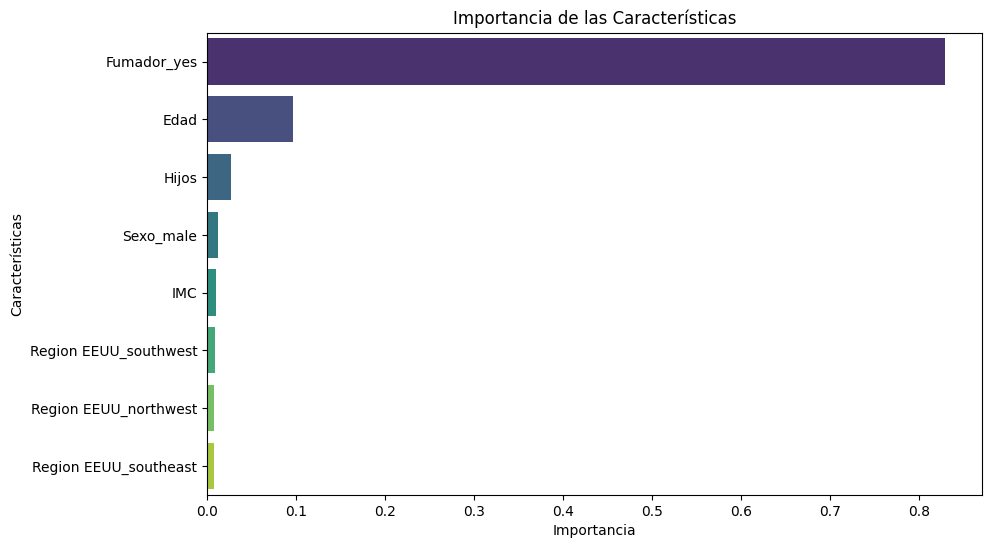

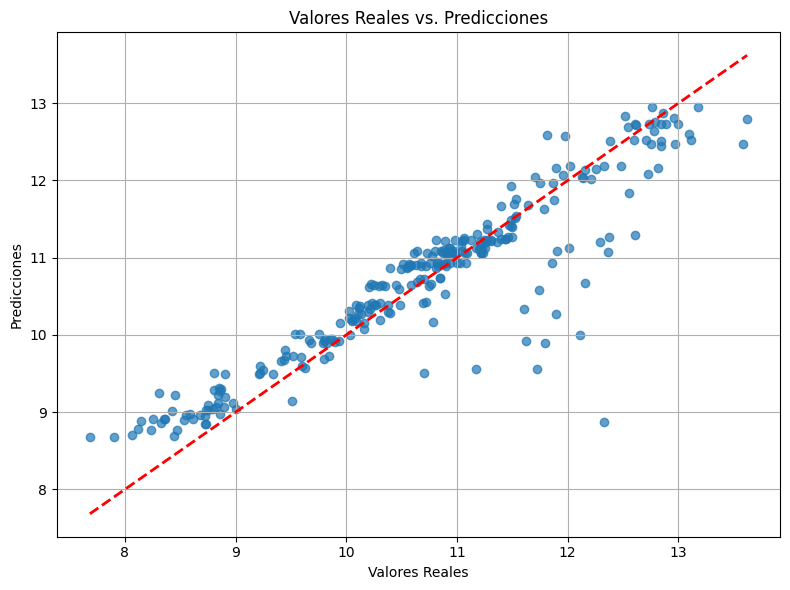

MAE: 0.3218006287518881
MSE: 0.2654514016287707
RMSE: 0.5152197605185292
R2 Score: 0.8393023914396657
RMSLE: 0.0445941178463541
MAPE: 3.03203404735558


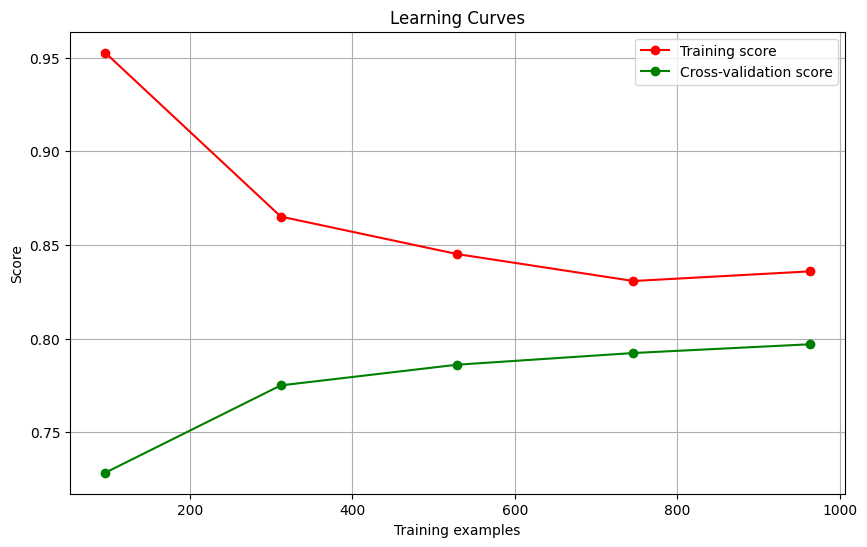

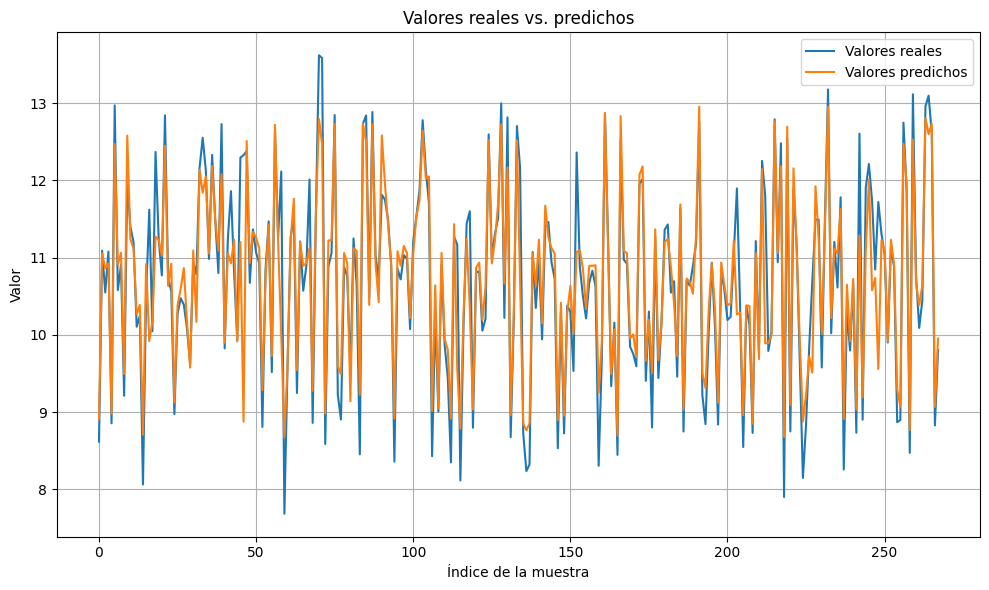

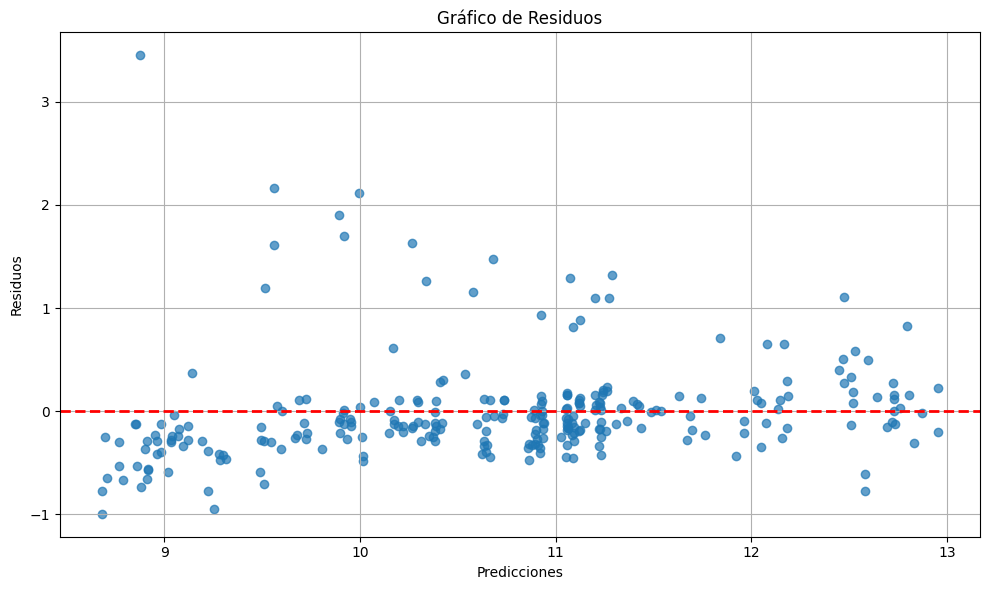

In [4]:
# Cargar una división específica (por ejemplo, la primera división)
X_train, X_test, y_train, y_test = load_split(1)

# Convertir y_train e y_test a series de pandas para asegurar que no haya problemas de tipo
y_train = y_train.squeeze().astype(float)
y_test = y_test.squeeze().astype(float)

# Verificar que y_train e y_test son de tipo float
assert y_train.dtype == float, f"y_train is not float but {y_train.dtype}"
assert y_test.dtype == float, f"y_test is not float but {y_test.dtype}"

# Aplicar One-Hot Encoding a las variables categóricas
categorical_cols = ['Sexo', 'Fumador', 'Region EEUU']
encoder = OneHotEncoder(drop='first', sparse_output=False)

# Ajustar y transformar las variables categóricas de X_train
X_train_encoded = encoder.fit_transform(X_train[categorical_cols])
X_train_encoded_df = pd.DataFrame(X_train_encoded, columns=encoder.get_feature_names_out(categorical_cols))

# Transformar las variables categóricas de X_test
X_test_encoded = encoder.transform(X_test[categorical_cols])
X_test_encoded_df = pd.DataFrame(X_test_encoded, columns=encoder.get_feature_names_out(categorical_cols))

# Concatenar las variables codificadas con las variables numéricas
X_train = pd.concat([X_train.drop(columns=categorical_cols).reset_index(drop=True), X_train_encoded_df], axis=1)
X_test = pd.concat([X_test.drop(columns=categorical_cols).reset_index(drop=True), X_test_encoded_df], axis=1)

# Asegurarse de que todos los tipos de datos sean numéricos
X_train = X_train.apply(pd.to_numeric, errors='coerce')
X_test = X_test.apply(pd.to_numeric, errors='coerce')

# XGB Regression
# Iniciar el modelo
model = XGBRegressor(random_state=42)

# Ajustar el modelo a los datos
model.fit(X_train, y_train)

# Realizar la validación cruzada con 10-fold
scores = cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', cv=10)
print(f"Cross-validated MSE: {-np.mean(scores)}")

# Optimización de los hiperparámetros
# Definir los valores para iterar y elegir los mejores parámetros
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5]
}

# Iniciar la búsqueda de hiperparámetros
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=10, scoring='neg_mean_squared_error', n_jobs=1, verbose=1)

# Ajustar a los datos de entrenamiento
grid_search.fit(X_train, y_train)

# Obtener los mejores parámetros
best_params = grid_search.best_params_
print("Best parameters:", best_params)

# Actualizar el modelo con los parámetros encontrados
model = grid_search.best_estimator_

# Características más importantes
# Obtener la importancia de cada variable
importances = model.feature_importances_

# Crear un conjunto de datos para las características y su importancia
feature_importances = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})

# Ordenar por importancia
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Seleccionar la misma paleta de colores utilizada anteriormente
n_colores = len(feature_importances)
colores = sns.color_palette('viridis', n_colors=n_colores)

# Graficar las características y su importancia
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances, palette=colores)
plt.title('Importancia de las Características')
plt.xlabel('Importancia')
plt.ylabel('Características')
plt.show()

# Realizar las predicciones
y_pred = model.predict(X_test)

# Asegurarnos de que y_test y y_pred sean del tipo float
y_test = y_test.astype(float)
y_pred = y_pred.astype(float)

# Gráfico de dispersión de los valores reales vs. predichos
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot(np.linspace(min(y_test), max(y_test), 100), np.linspace(min(y_test), max(y_test), 100), color='red', linestyle='--', linewidth=2)
plt.xlabel("Valores Reales")
plt.ylabel("Predicciones")
plt.title("Valores Reales vs. Predicciones")
plt.grid(True)
plt.tight_layout()
plt.show()

# Calcular MAE, MSE, RMSE, R2
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R2 Score:", r2)

# Calcular RMSLE (Root Mean Squared Logarithmic Error)
if (y_test >= 0).all() and (y_pred >= 0).all():
    rmsle = np.sqrt(mean_squared_log_error(y_test, y_pred))
    print("RMSLE:", rmsle)
else:
    print("RMSLE: cannot be calculated because some values are negative")

# Calcular MAPE (Mean Absolute Percentage Error)
def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape_score = mape(y_test, y_pred)
print("MAPE:", mape_score)

# Graficar la curva de aprendizaje (learning curve)
train_sizes, train_scores, test_scores = learning_curve(model, X_train, y_train, cv=10)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', color='r', label='Training score')
plt.plot(train_sizes, np.mean(test_scores, axis=1), 'o-', color='g', label='Cross-validation score')
plt.title('Learning Curves')
plt.xlabel('Training examples')
plt.ylabel('Score')
plt.legend(loc='best')
plt.grid()
plt.show()

# Gráfico de línea de los valores reales vs. predichos
plt.figure(figsize=(10, 6))
plt.plot(y_test, label="Valores reales")
plt.plot(y_pred, label="Valores predichos")
plt.xlabel("Índice de la muestra")
plt.ylabel("Valor")
plt.title("Valores reales vs. predichos")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Calcular residuos
residuos = y_test - y_pred

# Graficar los residuos
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuos, alpha=0.7)
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
plt.xlabel("Predicciones")
plt.ylabel("Residuos")
plt.title("Gráfico de Residuos")
plt.grid(True)
plt.tight_layout()
plt.show()

Cross-validated MSE: 0.39981366253705697
Fitting 10 folds for each of 27 candidates, totalling 270 fits
Best parameters: {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 300}


C:\Users\HP\AppData\Local\Temp\ipykernel_11284\96613632.py:80: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importances, palette=colores)


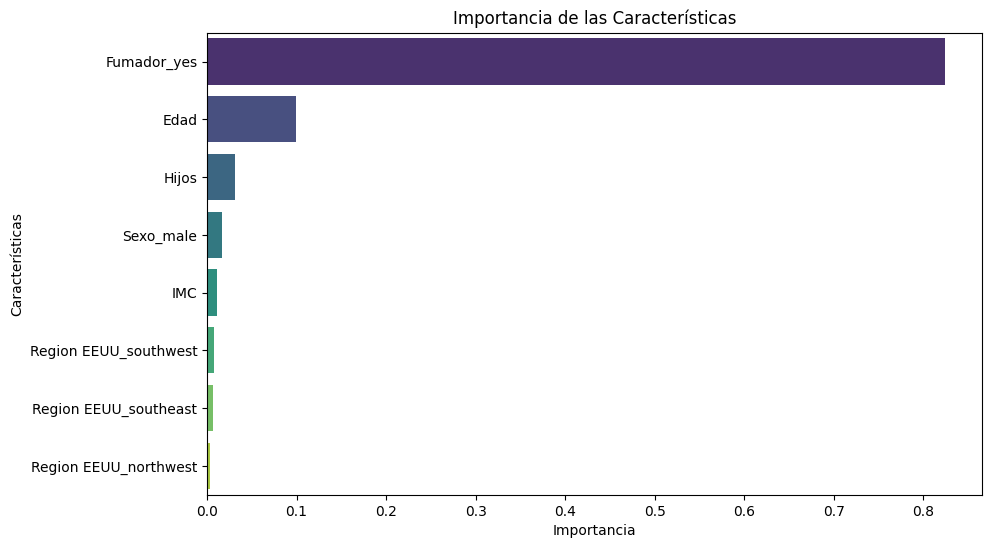

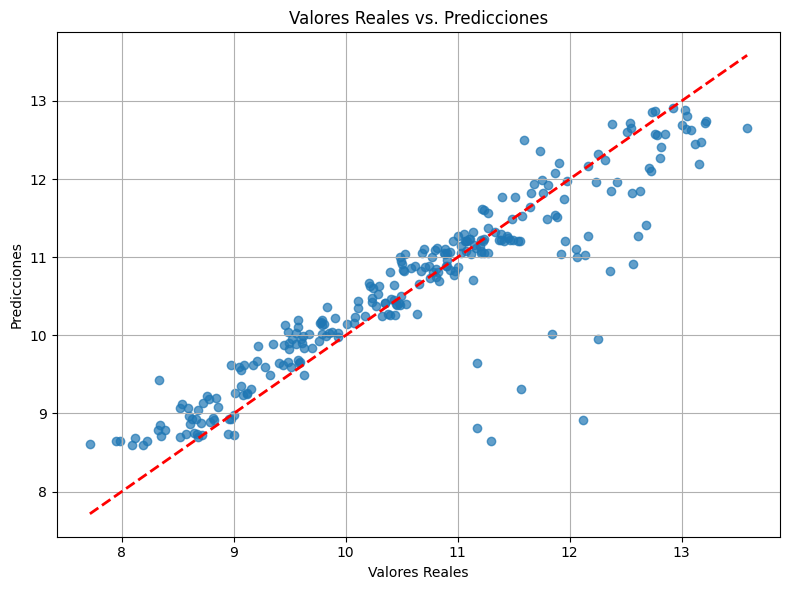

MAE: 0.3527836357511451
MSE: 0.30261722735434715
RMSE: 0.5501065599993761
R2 Score: 0.831138980039668
RMSLE: 0.047801416087791426
MAPE: 3.318646419365219


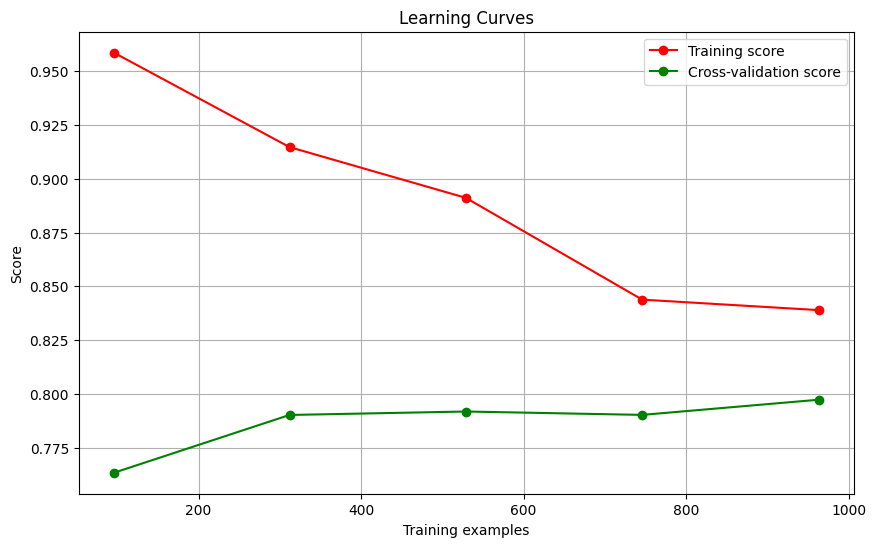

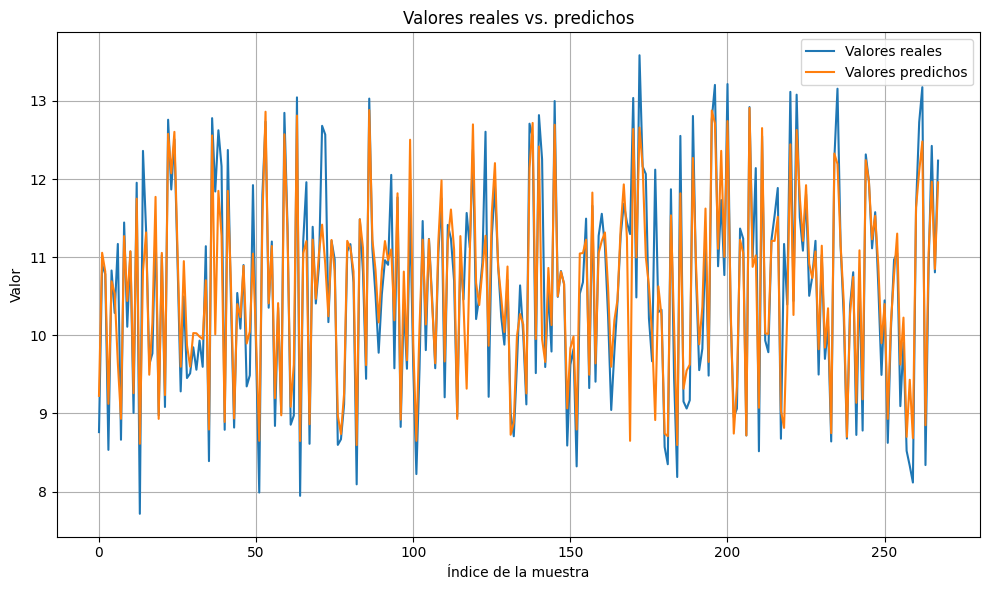

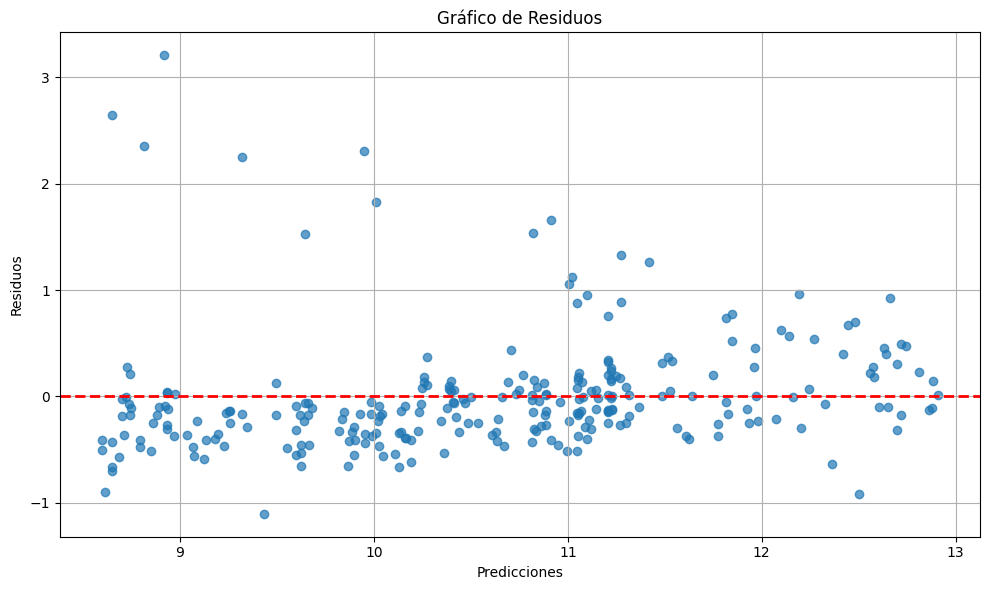

In [5]:
# Cargar una división específica (por ejemplo, la primera división)
X_train, X_test, y_train, y_test = load_split(2)

# Convertir y_train e y_test a series de pandas para asegurar que no haya problemas de tipo
y_train = y_train.squeeze().astype(float)
y_test = y_test.squeeze().astype(float)

# Verificar que y_train e y_test son de tipo float
assert y_train.dtype == float, f"y_train is not float but {y_train.dtype}"
assert y_test.dtype == float, f"y_test is not float but {y_test.dtype}"

# Aplicar One-Hot Encoding a las variables categóricas
categorical_cols = ['Sexo', 'Fumador', 'Region EEUU']
encoder = OneHotEncoder(drop='first', sparse_output=False)

# Ajustar y transformar las variables categóricas de X_train
X_train_encoded = encoder.fit_transform(X_train[categorical_cols])
X_train_encoded_df = pd.DataFrame(X_train_encoded, columns=encoder.get_feature_names_out(categorical_cols))

# Transformar las variables categóricas de X_test
X_test_encoded = encoder.transform(X_test[categorical_cols])
X_test_encoded_df = pd.DataFrame(X_test_encoded, columns=encoder.get_feature_names_out(categorical_cols))

# Concatenar las variables codificadas con las variables numéricas
X_train = pd.concat([X_train.drop(columns=categorical_cols).reset_index(drop=True), X_train_encoded_df], axis=1)
X_test = pd.concat([X_test.drop(columns=categorical_cols).reset_index(drop=True), X_test_encoded_df], axis=1)

# Asegurarse de que todos los tipos de datos sean numéricos
X_train = X_train.apply(pd.to_numeric, errors='coerce')
X_test = X_test.apply(pd.to_numeric, errors='coerce')

# XGB Regression
# Iniciar el modelo
model = XGBRegressor(random_state=42)

# Ajustar el modelo a los datos
model.fit(X_train, y_train)

# Realizar la validación cruzada con 10-fold
scores = cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', cv=10)
print(f"Cross-validated MSE: {-np.mean(scores)}")

# Optimización de los hiperparámetros
# Definir los valores para iterar y elegir los mejores parámetros
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5]
}

# Iniciar la búsqueda de hiperparámetros
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=10, scoring='neg_mean_squared_error', n_jobs=1, verbose=1)

# Ajustar a los datos de entrenamiento
grid_search.fit(X_train, y_train)

# Obtener los mejores parámetros
best_params = grid_search.best_params_
print("Best parameters:", best_params)

# Actualizar el modelo con los parámetros encontrados
model = grid_search.best_estimator_

# Características más importantes
# Obtener la importancia de cada variable
importances = model.feature_importances_

# Crear un conjunto de datos para las características y su importancia
feature_importances = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})

# Ordenar por importancia
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Seleccionar la misma paleta de colores utilizada anteriormente
n_colores = len(feature_importances)
colores = sns.color_palette('viridis', n_colors=n_colores)

# Graficar las características y su importancia
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances, palette=colores)
plt.title('Importancia de las Características')
plt.xlabel('Importancia')
plt.ylabel('Características')
plt.show()

# Realizar las predicciones
y_pred = model.predict(X_test)

# Asegurarnos de que y_test y y_pred sean del tipo float
y_test = y_test.astype(float)
y_pred = y_pred.astype(float)

# Gráfico de dispersión de los valores reales vs. predichos
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot(np.linspace(min(y_test), max(y_test), 100), np.linspace(min(y_test), max(y_test), 100), color='red', linestyle='--', linewidth=2)
plt.xlabel("Valores Reales")
plt.ylabel("Predicciones")
plt.title("Valores Reales vs. Predicciones")
plt.grid(True)
plt.tight_layout()
plt.show()

# Calcular MAE, MSE, RMSE, R2
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R2 Score:", r2)

# Calcular RMSLE (Root Mean Squared Logarithmic Error)
if (y_test >= 0).all() and (y_pred >= 0).all():
    rmsle = np.sqrt(mean_squared_log_error(y_test, y_pred))
    print("RMSLE:", rmsle)
else:
    print("RMSLE: cannot be calculated because some values are negative")

# Calcular MAPE (Mean Absolute Percentage Error)
def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape_score = mape(y_test, y_pred)
print("MAPE:", mape_score)

# Graficar la curva de aprendizaje (learning curve)
train_sizes, train_scores, test_scores = learning_curve(model, X_train, y_train, cv=10)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', color='r', label='Training score')
plt.plot(train_sizes, np.mean(test_scores, axis=1), 'o-', color='g', label='Cross-validation score')
plt.title('Learning Curves')
plt.xlabel('Training examples')
plt.ylabel('Score')
plt.legend(loc='best')
plt.grid()
plt.show()

# Gráfico de línea de los valores reales vs. predichos
plt.figure(figsize=(10, 6))
plt.plot(y_test, label="Valores reales")
plt.plot(y_pred, label="Valores predichos")
plt.xlabel("Índice de la muestra")
plt.ylabel("Valor")
plt.title("Valores reales vs. predichos")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Calcular residuos
residuos = y_test - y_pred

# Graficar los residuos
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuos, alpha=0.7)
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
plt.xlabel("Predicciones")
plt.ylabel("Residuos")
plt.title("Gráfico de Residuos")
plt.grid(True)
plt.tight_layout()
plt.show()

Cross-validated MSE: 0.3540851486446944
Fitting 10 folds for each of 27 candidates, totalling 270 fits
Best parameters: {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 300}


C:\Users\HP\AppData\Local\Temp\ipykernel_11284\560353496.py:80: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importances, palette=colores)


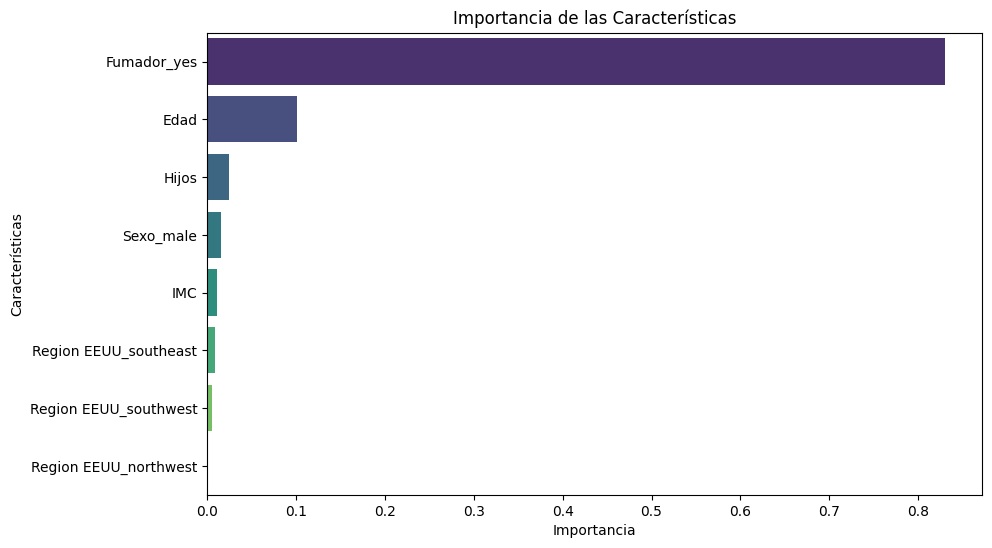

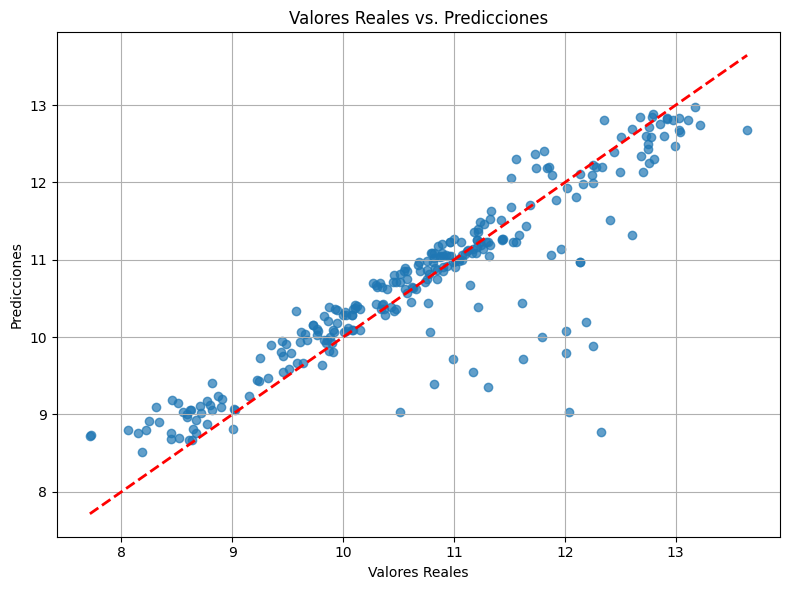

MAE: 0.3503725216969018
MSE: 0.33982974622239054
RMSE: 0.5829491797939084
R2 Score: 0.7948007765409062
RMSLE: 0.05070866746010852
MAPE: 3.277866918417999


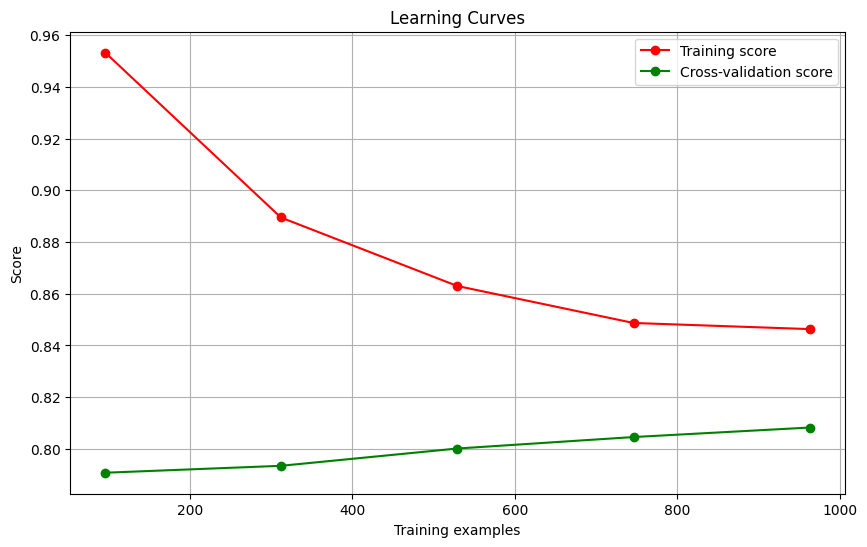

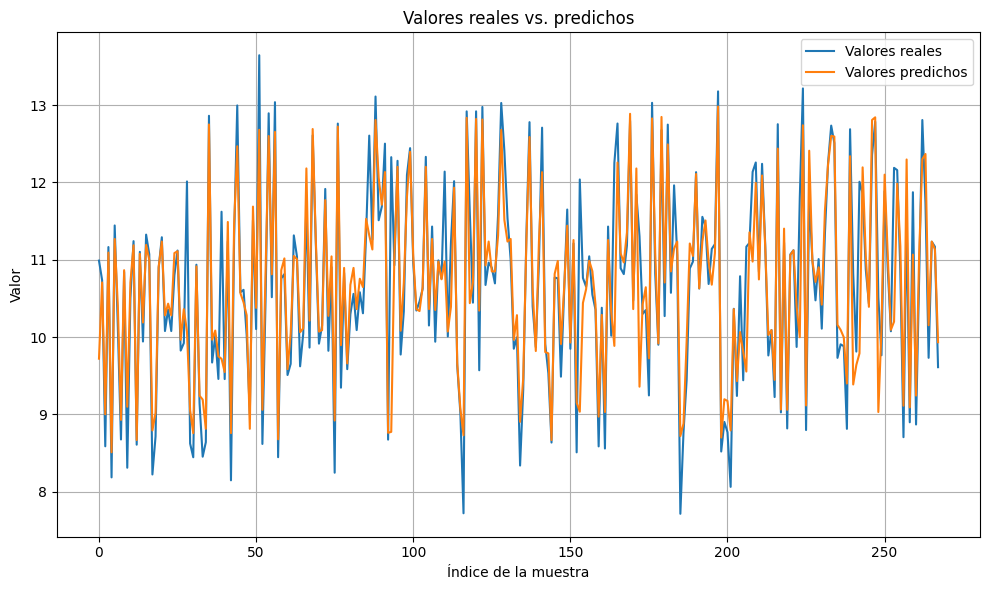

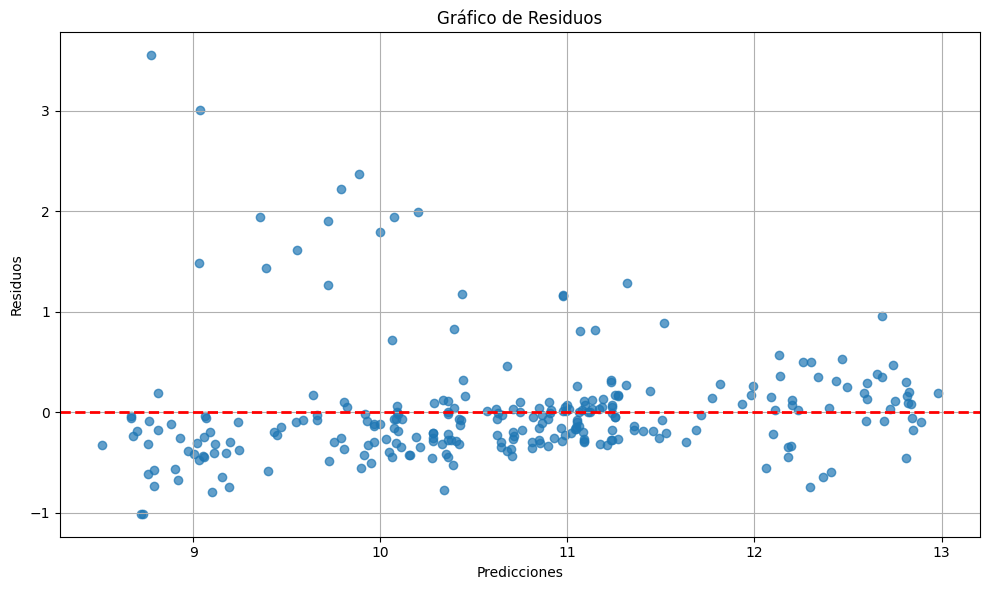

In [6]:
# Cargar una división específica (por ejemplo, la primera división)
X_train, X_test, y_train, y_test = load_split(3)

# Convertir y_train e y_test a series de pandas para asegurar que no haya problemas de tipo
y_train = y_train.squeeze().astype(float)
y_test = y_test.squeeze().astype(float)

# Verificar que y_train e y_test son de tipo float
assert y_train.dtype == float, f"y_train is not float but {y_train.dtype}"
assert y_test.dtype == float, f"y_test is not float but {y_test.dtype}"

# Aplicar One-Hot Encoding a las variables categóricas
categorical_cols = ['Sexo', 'Fumador', 'Region EEUU']
encoder = OneHotEncoder(drop='first', sparse_output=False)

# Ajustar y transformar las variables categóricas de X_train
X_train_encoded = encoder.fit_transform(X_train[categorical_cols])
X_train_encoded_df = pd.DataFrame(X_train_encoded, columns=encoder.get_feature_names_out(categorical_cols))

# Transformar las variables categóricas de X_test
X_test_encoded = encoder.transform(X_test[categorical_cols])
X_test_encoded_df = pd.DataFrame(X_test_encoded, columns=encoder.get_feature_names_out(categorical_cols))

# Concatenar las variables codificadas con las variables numéricas
X_train = pd.concat([X_train.drop(columns=categorical_cols).reset_index(drop=True), X_train_encoded_df], axis=1)
X_test = pd.concat([X_test.drop(columns=categorical_cols).reset_index(drop=True), X_test_encoded_df], axis=1)

# Asegurarse de que todos los tipos de datos sean numéricos
X_train = X_train.apply(pd.to_numeric, errors='coerce')
X_test = X_test.apply(pd.to_numeric, errors='coerce')

# XGB Regression
# Iniciar el modelo
model = XGBRegressor(random_state=42)

# Ajustar el modelo a los datos
model.fit(X_train, y_train)

# Realizar la validación cruzada con 10-fold
scores = cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', cv=10)
print(f"Cross-validated MSE: {-np.mean(scores)}")

# Optimización de los hiperparámetros
# Definir los valores para iterar y elegir los mejores parámetros
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5]
}

# Iniciar la búsqueda de hiperparámetros
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=10, scoring='neg_mean_squared_error', n_jobs=1, verbose=1)

# Ajustar a los datos de entrenamiento
grid_search.fit(X_train, y_train)

# Obtener los mejores parámetros
best_params = grid_search.best_params_
print("Best parameters:", best_params)

# Actualizar el modelo con los parámetros encontrados
model = grid_search.best_estimator_

# Características más importantes
# Obtener la importancia de cada variable
importances = model.feature_importances_

# Crear un conjunto de datos para las características y su importancia
feature_importances = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})

# Ordenar por importancia
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Seleccionar la misma paleta de colores utilizada anteriormente
n_colores = len(feature_importances)
colores = sns.color_palette('viridis', n_colors=n_colores)

# Graficar las características y su importancia
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances, palette=colores)
plt.title('Importancia de las Características')
plt.xlabel('Importancia')
plt.ylabel('Características')
plt.show()

# Realizar las predicciones
y_pred = model.predict(X_test)

# Asegurarnos de que y_test y y_pred sean del tipo float
y_test = y_test.astype(float)
y_pred = y_pred.astype(float)

# Gráfico de dispersión de los valores reales vs. predichos
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot(np.linspace(min(y_test), max(y_test), 100), np.linspace(min(y_test), max(y_test), 100), color='red', linestyle='--', linewidth=2)
plt.xlabel("Valores Reales")
plt.ylabel("Predicciones")
plt.title("Valores Reales vs. Predicciones")
plt.grid(True)
plt.tight_layout()
plt.show()

# Calcular MAE, MSE, RMSE, R2
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R2 Score:", r2)

# Calcular RMSLE (Root Mean Squared Logarithmic Error)
if (y_test >= 0).all() and (y_pred >= 0).all():
    rmsle = np.sqrt(mean_squared_log_error(y_test, y_pred))
    print("RMSLE:", rmsle)
else:
    print("RMSLE: cannot be calculated because some values are negative")

# Calcular MAPE (Mean Absolute Percentage Error)
def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape_score = mape(y_test, y_pred)
print("MAPE:", mape_score)

# Graficar la curva de aprendizaje (learning curve)
train_sizes, train_scores, test_scores = learning_curve(model, X_train, y_train, cv=10)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', color='r', label='Training score')
plt.plot(train_sizes, np.mean(test_scores, axis=1), 'o-', color='g', label='Cross-validation score')
plt.title('Learning Curves')
plt.xlabel('Training examples')
plt.ylabel('Score')
plt.legend(loc='best')
plt.grid()
plt.show()

# Gráfico de línea de los valores reales vs. predichos
plt.figure(figsize=(10, 6))
plt.plot(y_test, label="Valores reales")
plt.plot(y_pred, label="Valores predichos")
plt.xlabel("Índice de la muestra")
plt.ylabel("Valor")
plt.title("Valores reales vs. predichos")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Calcular residuos
residuos = y_test - y_pred

# Graficar los residuos
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuos, alpha=0.7)
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
plt.xlabel("Predicciones")
plt.ylabel("Residuos")
plt.title("Gráfico de Residuos")
plt.grid(True)
plt.tight_layout()
plt.show()

Cross-validated MSE: 0.36862936742512376
Fitting 10 folds for each of 27 candidates, totalling 270 fits
Best parameters: {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 300}


C:\Users\HP\AppData\Local\Temp\ipykernel_11284\930557295.py:80: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importances, palette=colores)


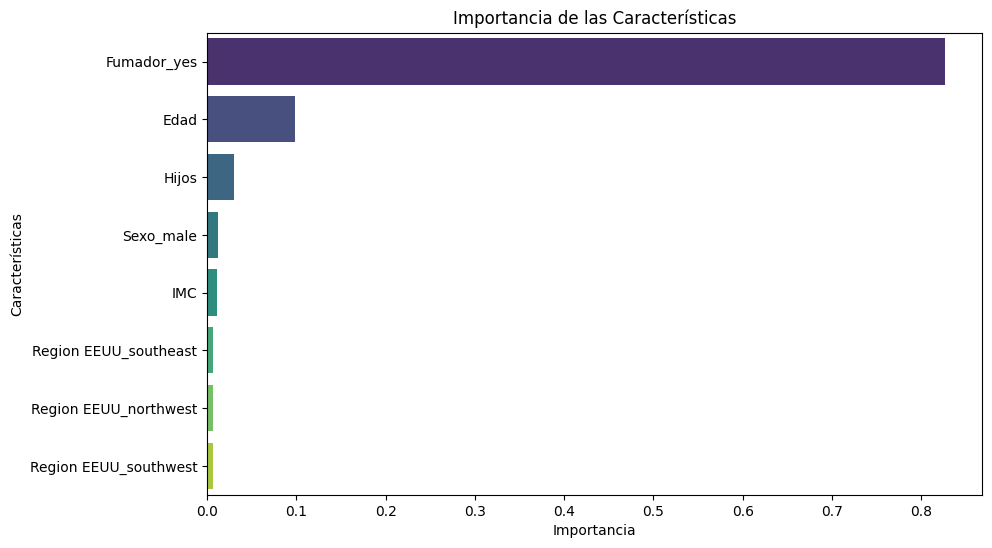

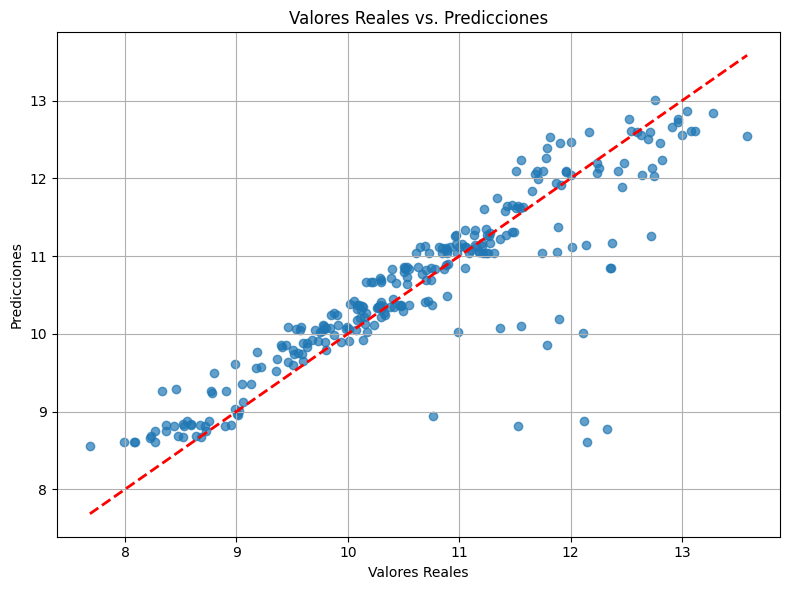

MAE: 0.3575981966722946
MSE: 0.36508048253673014
RMSE: 0.604218902829703
R2 Score: 0.7689490472099093
RMSLE: 0.05248923235693184
MAPE: 3.3198744842931798


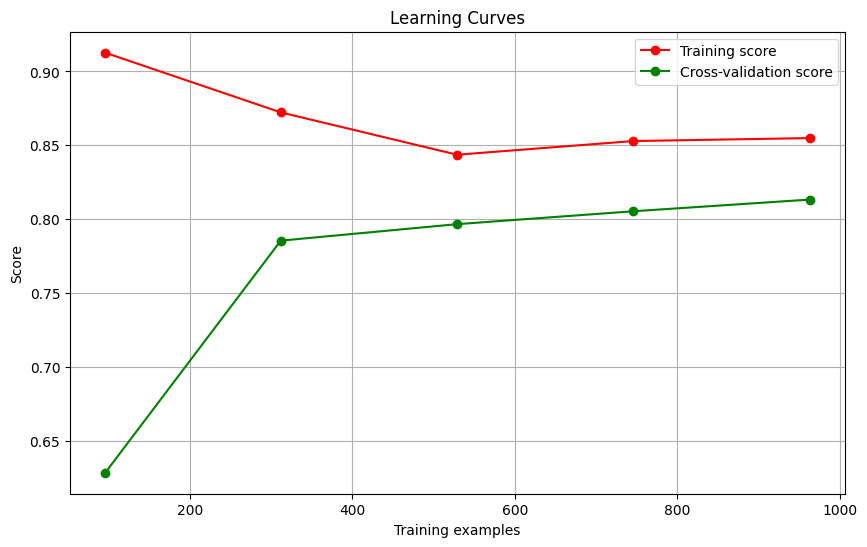

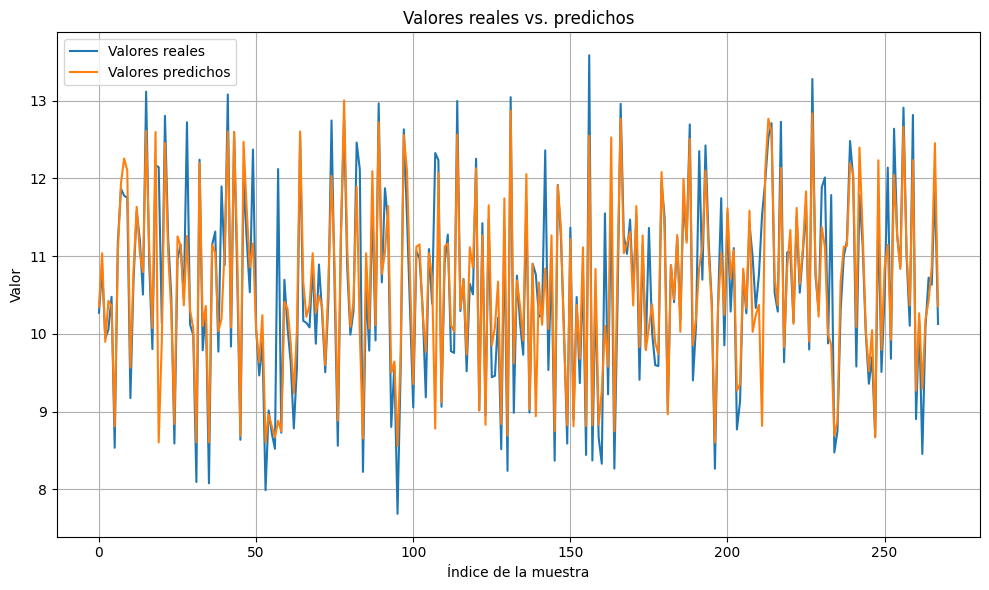

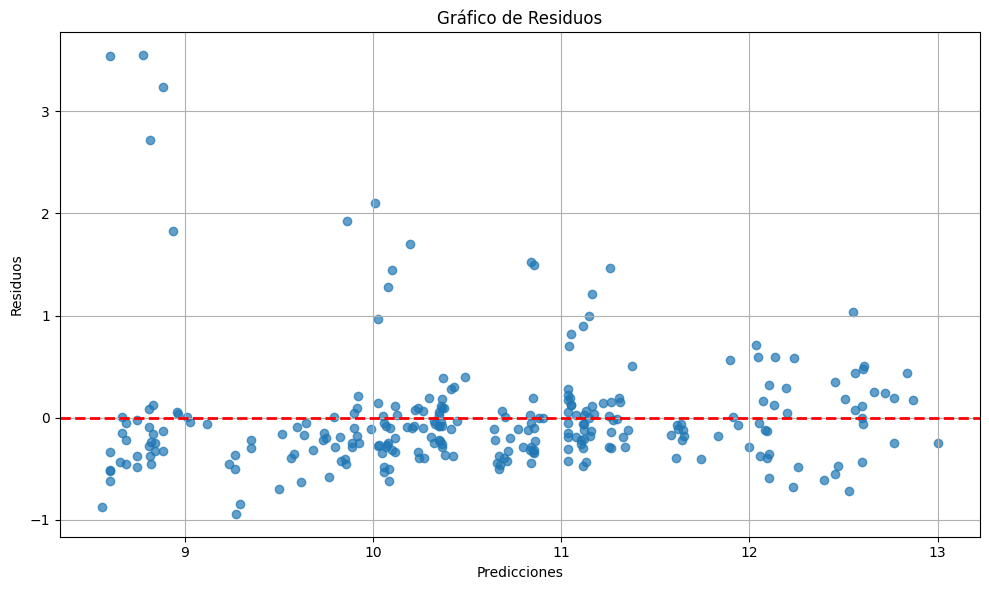

In [7]:
# Cargar una división específica (por ejemplo, la primera división)
X_train, X_test, y_train, y_test = load_split(4)

# Convertir y_train e y_test a series de pandas para asegurar que no haya problemas de tipo
y_train = y_train.squeeze().astype(float)
y_test = y_test.squeeze().astype(float)

# Verificar que y_train e y_test son de tipo float
assert y_train.dtype == float, f"y_train is not float but {y_train.dtype}"
assert y_test.dtype == float, f"y_test is not float but {y_test.dtype}"

# Aplicar One-Hot Encoding a las variables categóricas
categorical_cols = ['Sexo', 'Fumador', 'Region EEUU']
encoder = OneHotEncoder(drop='first', sparse_output=False)

# Ajustar y transformar las variables categóricas de X_train
X_train_encoded = encoder.fit_transform(X_train[categorical_cols])
X_train_encoded_df = pd.DataFrame(X_train_encoded, columns=encoder.get_feature_names_out(categorical_cols))

# Transformar las variables categóricas de X_test
X_test_encoded = encoder.transform(X_test[categorical_cols])
X_test_encoded_df = pd.DataFrame(X_test_encoded, columns=encoder.get_feature_names_out(categorical_cols))

# Concatenar las variables codificadas con las variables numéricas
X_train = pd.concat([X_train.drop(columns=categorical_cols).reset_index(drop=True), X_train_encoded_df], axis=1)
X_test = pd.concat([X_test.drop(columns=categorical_cols).reset_index(drop=True), X_test_encoded_df], axis=1)

# Asegurarse de que todos los tipos de datos sean numéricos
X_train = X_train.apply(pd.to_numeric, errors='coerce')
X_test = X_test.apply(pd.to_numeric, errors='coerce')

# XGB Regression
# Iniciar el modelo
model = XGBRegressor(random_state=42)

# Ajustar el modelo a los datos
model.fit(X_train, y_train)

# Realizar la validación cruzada con 10-fold
scores = cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', cv=10)
print(f"Cross-validated MSE: {-np.mean(scores)}")

# Optimización de los hiperparámetros
# Definir los valores para iterar y elegir los mejores parámetros
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5]
}

# Iniciar la búsqueda de hiperparámetros
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=10, scoring='neg_mean_squared_error', n_jobs=1, verbose=1)

# Ajustar a los datos de entrenamiento
grid_search.fit(X_train, y_train)

# Obtener los mejores parámetros
best_params = grid_search.best_params_
print("Best parameters:", best_params)

# Actualizar el modelo con los parámetros encontrados
model = grid_search.best_estimator_

# Características más importantes
# Obtener la importancia de cada variable
importances = model.feature_importances_

# Crear un conjunto de datos para las características y su importancia
feature_importances = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})

# Ordenar por importancia
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Seleccionar la misma paleta de colores utilizada anteriormente
n_colores = len(feature_importances)
colores = sns.color_palette('viridis', n_colors=n_colores)

# Graficar las características y su importancia
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances, palette=colores)
plt.title('Importancia de las Características')
plt.xlabel('Importancia')
plt.ylabel('Características')
plt.show()

# Realizar las predicciones
y_pred = model.predict(X_test)

# Asegurarnos de que y_test y y_pred sean del tipo float
y_test = y_test.astype(float)
y_pred = y_pred.astype(float)

# Gráfico de dispersión de los valores reales vs. predichos
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot(np.linspace(min(y_test), max(y_test), 100), np.linspace(min(y_test), max(y_test), 100), color='red', linestyle='--', linewidth=2)
plt.xlabel("Valores Reales")
plt.ylabel("Predicciones")
plt.title("Valores Reales vs. Predicciones")
plt.grid(True)
plt.tight_layout()
plt.show()

# Calcular MAE, MSE, RMSE, R2
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R2 Score:", r2)

# Calcular RMSLE (Root Mean Squared Logarithmic Error)
if (y_test >= 0).all() and (y_pred >= 0).all():
    rmsle = np.sqrt(mean_squared_log_error(y_test, y_pred))
    print("RMSLE:", rmsle)
else:
    print("RMSLE: cannot be calculated because some values are negative")

# Calcular MAPE (Mean Absolute Percentage Error)
def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape_score = mape(y_test, y_pred)
print("MAPE:", mape_score)

# Graficar la curva de aprendizaje (learning curve)
train_sizes, train_scores, test_scores = learning_curve(model, X_train, y_train, cv=10)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', color='r', label='Training score')
plt.plot(train_sizes, np.mean(test_scores, axis=1), 'o-', color='g', label='Cross-validation score')
plt.title('Learning Curves')
plt.xlabel('Training examples')
plt.ylabel('Score')
plt.legend(loc='best')
plt.grid()
plt.show()

# Gráfico de línea de los valores reales vs. predichos
plt.figure(figsize=(10, 6))
plt.plot(y_test, label="Valores reales")
plt.plot(y_pred, label="Valores predichos")
plt.xlabel("Índice de la muestra")
plt.ylabel("Valor")
plt.title("Valores reales vs. predichos")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Calcular residuos
residuos = y_test - y_pred

# Graficar los residuos
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuos, alpha=0.7)
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
plt.xlabel("Predicciones")
plt.ylabel("Residuos")
plt.title("Gráfico de Residuos")
plt.grid(True)
plt.tight_layout()
plt.show()

Cross-validated MSE: 43535567.538454205
Fitting 10 folds for each of 432 candidates, totalling 4320 fits
Best parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}


C:\Users\HP\AppData\Local\Temp\ipykernel_19036\754166147.py:70: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importances, palette=colores)


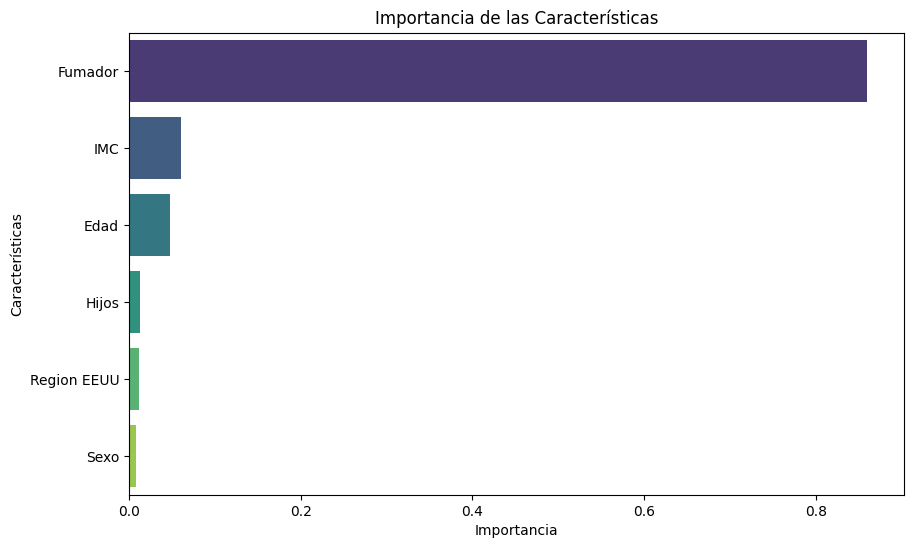

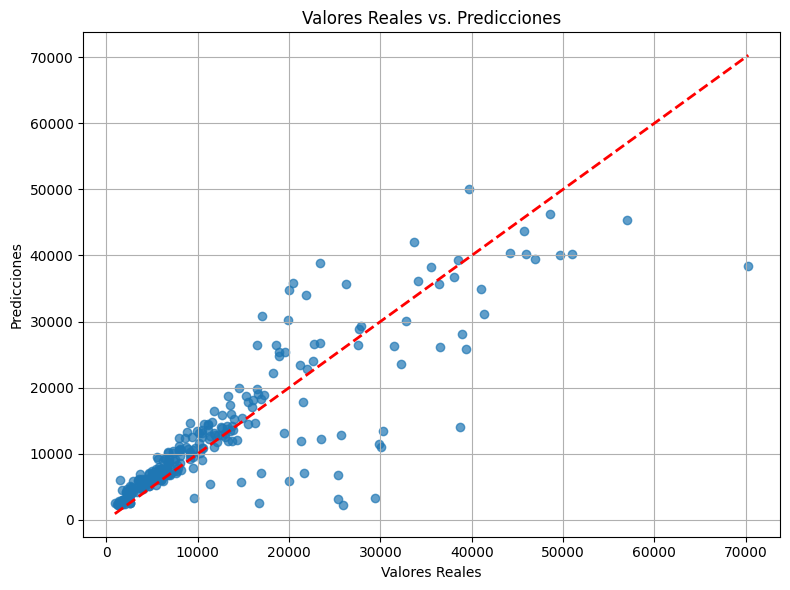

MAE: 3518.4011380232623
MSE: 36004378.205025315
RMSE: 6000.364839326465
R2 Score: 0.7421789300824824
RMSLE: 0.4688587242905354
MAPE: 34.67355668711187


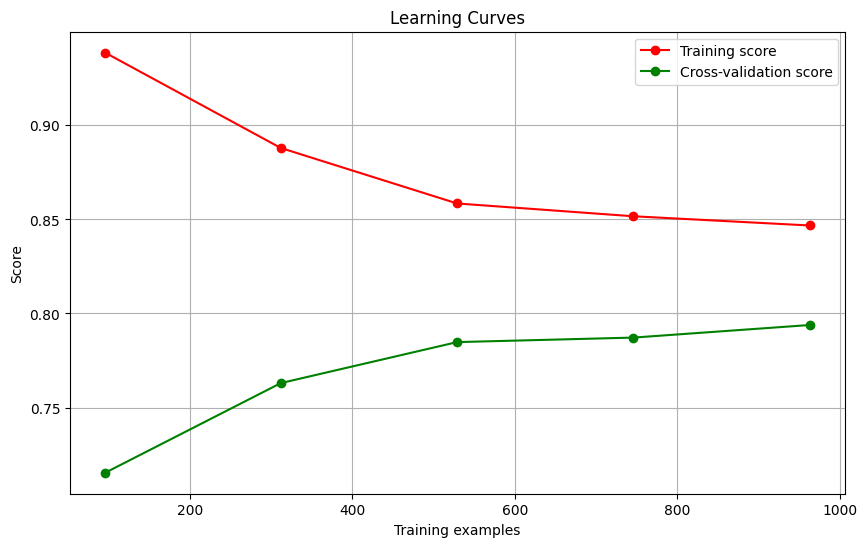

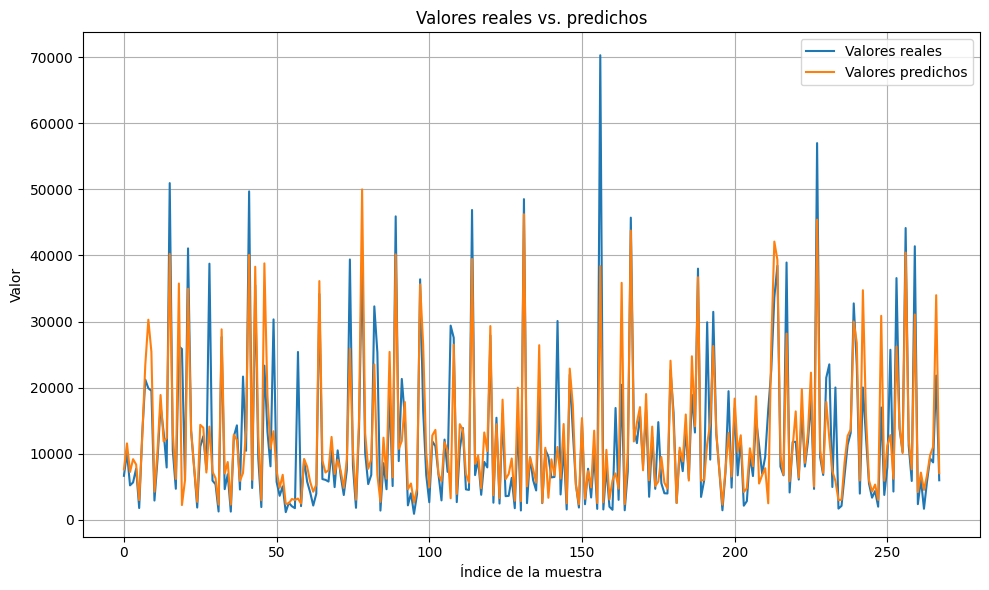

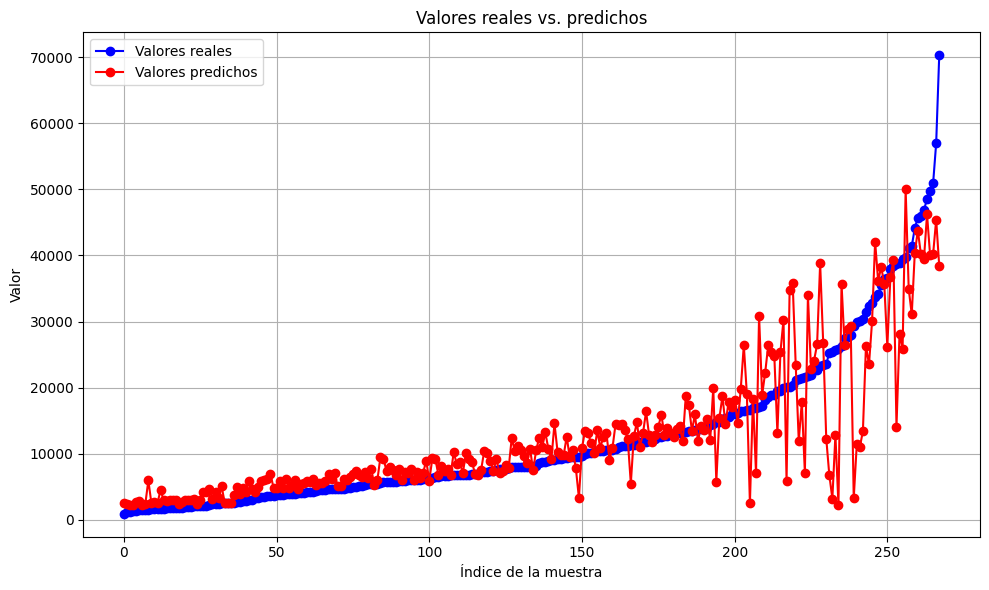

In [7]:
# Cargar una división específica (por ejemplo, la primera división)
X_train, X_test, y_train, y_test = load_split(4)

# Codificar las variables categóricas después de cargar la división
le = LabelEncoder()

for column in ['Sexo', 'Fumador', 'Region EEUU']:
    X_train[column] = le.fit_transform(X_train[column])
    X_test[column] = le.transform(X_test[column])

# Convertir y_train e y_test a series de pandas para asegurar que no haya problemas de tipo
y_train = y_train.squeeze().astype(float)
y_test = y_test.squeeze().astype(float)

# Convertir y_test a array de NumPy para asegurar la compatibilidad de tipos
y_test = np.array(y_test)

# Importar XGBoost
from xgboost import XGBRegressor

# Iniciamos el modelo
model = XGBRegressor(random_state=42)

# Ajustamos el modelo a los datos
model.fit(X_train, y_train)

# Realizamos la validación cruzada con 10-fold
scores = cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', cv=10)
print(f"Cross-validated MSE: {-np.mean(scores)}")

# Optimización de los Hiperparámetros
# Definimos los valores para iterar y elegir los mejores parámetros
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# Iniciamos la búsqueda de hiperparámetros
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=10, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)

# Ajustamos a los datos de entrenamiento
grid_search.fit(X_train, y_train)

# Obtenemos los mejores parámetros
best_params = grid_search.best_params_
print("Best parameters:", best_params)

# Actualizamos el modelo con los parámetros encontrados
model = grid_search.best_estimator_

# Características más importantes
# Obtenemos la importancia de cada variable
importances = model.feature_importances_

# Creamos un conjunto de datos para las características y su importancia
feature_importances = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})

# Ordenamos por importancia
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Seleccionamos la misma paleta de colores utilizada anteriormente
n_colores = len(feature_importances)
colores = sns.color_palette('viridis', n_colors=n_colores)

# Graficamos las características y su importancia
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances, palette=colores)
plt.title('Importancia de las Características')
plt.xlabel('Importancia')
plt.ylabel('Características')
plt.show()

# Realizamos las predicciones
y_pred = model.predict(X_test)

# Asegurarnos de que y_test y y_pred sean del tipo float
y_test = y_test.astype(float)
y_pred = y_pred.astype(float)

# Gráfico de dispersión de los valores reales vs. predichos
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot(np.linspace(min(y_test), max(y_test), 100), np.linspace(min(y_test), max(y_test), 100), color='red', linestyle='--', linewidth=2)
plt.xlabel("Valores Reales")
plt.ylabel("Predicciones")
plt.title("Valores Reales vs. Predicciones")
plt.grid(True)
plt.tight_layout()
plt.show()

# Calculamos MAE, MSE, RMSE, R2
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R2 Score:", r2)

# Calculamos RMSLE (Root Mean Squared Logarithmic Error)
if (y_test >= 0).all() and (y_pred >= 0).all():
    rmsle = np.sqrt(mean_squared_log_error(y_test, y_pred))
    print("RMSLE:", rmsle)
else:
    print("RMSLE: cannot be calculated because some values are negative")

# Calculamos MAPE (Mean Absolute Percentage Error)
def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape_score = mape(y_test, y_pred)
print("MAPE:", mape_score)

# Graficamos la curva de aprendizaje (learning curve)
train_sizes, train_scores, test_scores = learning_curve(model, X_train, y_train, cv=10)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', color='r', label='Training score')
plt.plot(train_sizes, np.mean(test_scores, axis=1), 'o-', color='g', label='Cross-validation score')
plt.title('Learning Curves')
plt.xlabel('Training examples')
plt.ylabel('Score')
plt.legend(loc='best')
plt.grid()
plt.show()

# Gráfico de línea de los valores reales vs. predichos
plt.figure(figsize=(10, 6))
plt.plot(y_test, label="Valores reales")
plt.plot(y_pred, label="Valores predichos")
plt.xlabel("Índice de la muestra")
plt.ylabel("Valor")
plt.title("Valores reales vs. predichos")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Crear un array con el índice de las muestras
indices = np.arange(len(y_test))

# Ordenar los valores reales y predichos por los valores reales
sorted_indices = np.argsort(y_test)

# Graficar los valores reales y predichos
plt.figure(figsize=(10, 6))
plt.plot(indices, y_test[sorted_indices], 'b-', marker='o', label='Valores reales')
plt.plot(indices, y_pred[sorted_indices], 'r-', marker='o', label='Valores predichos')
plt.xlabel('Índice de la muestra')
plt.ylabel('Valor')
plt.title('Valores reales vs. predichos')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Cross-validated MSE: 38011323.696980655
Fitting 10 folds for each of 27 candidates, totalling 270 fits
Best parameters: {'depth': 3, 'iterations': 100, 'learning_rate': 0.1}


C:\Users\HP\AppData\Local\Temp\ipykernel_8960\2906241038.py:85: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importances, palette=colores)


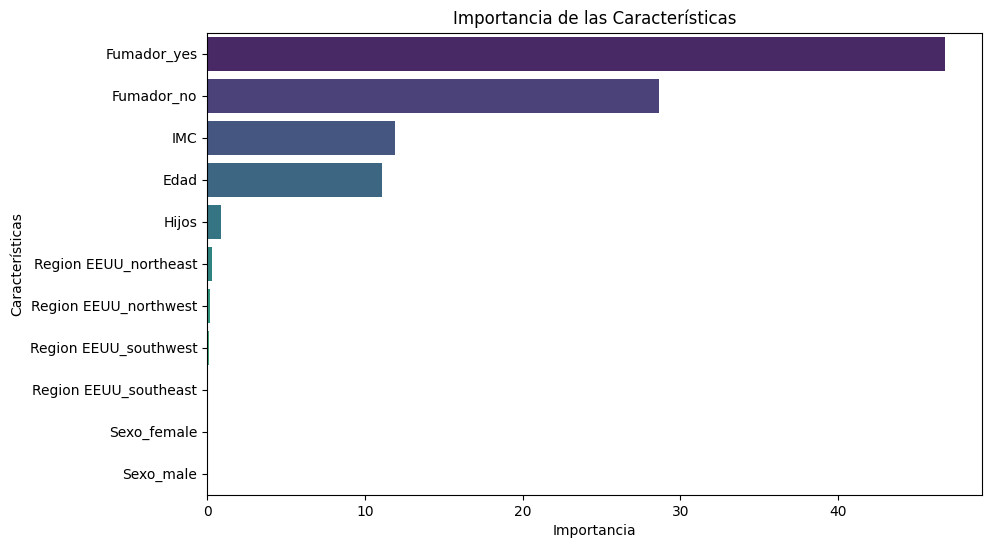

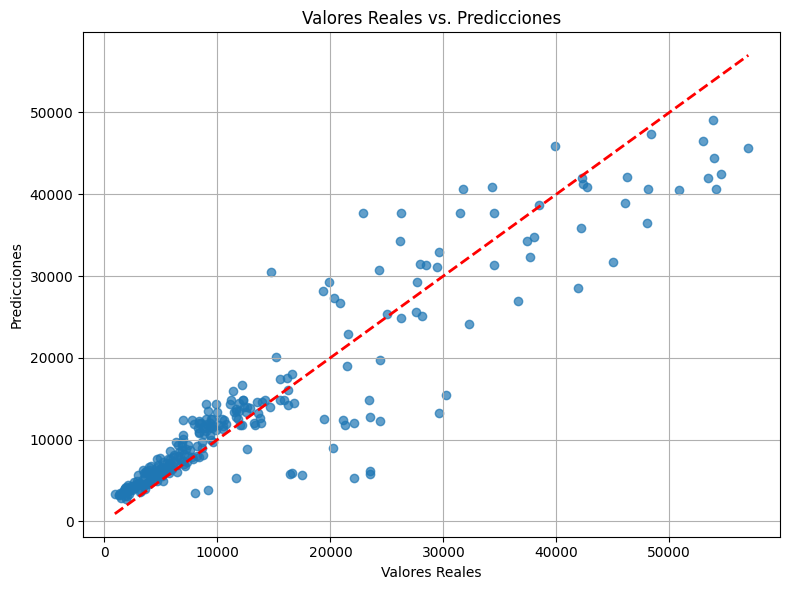

MAE: 3286.6332426105955
MSE: 23987931.932636447
RMSE: 4897.7476387250135
R2 Score: 0.8583498381159099
RMSLE: 0.4064924527737682
MAPE: 34.92952519127559


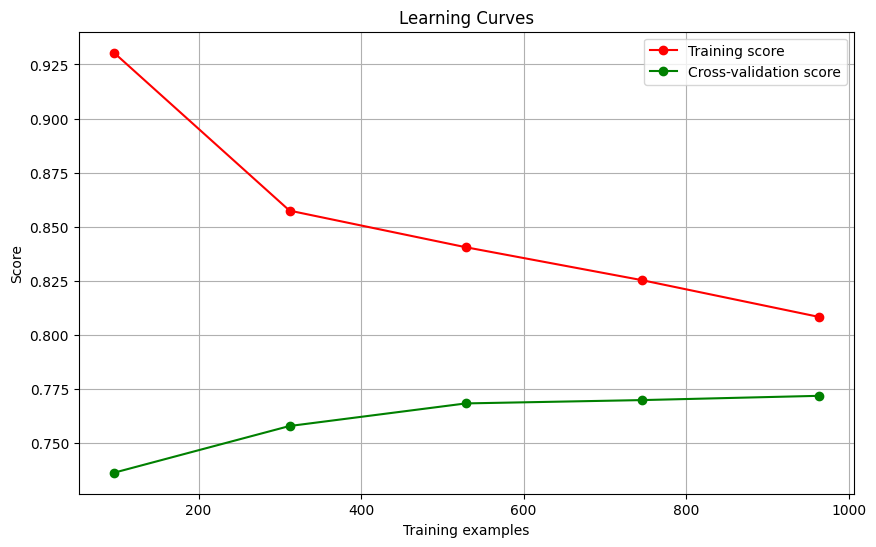

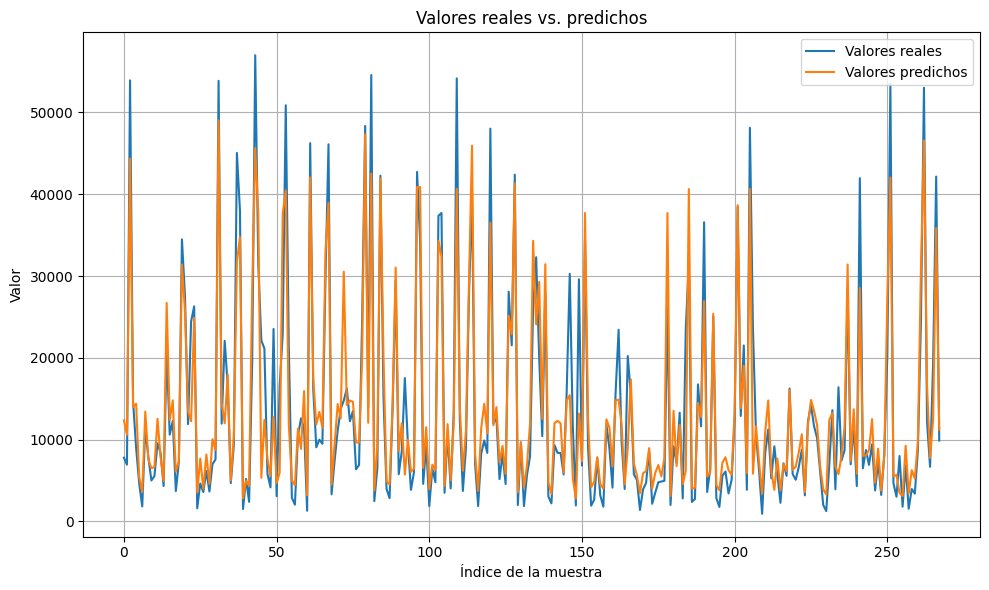

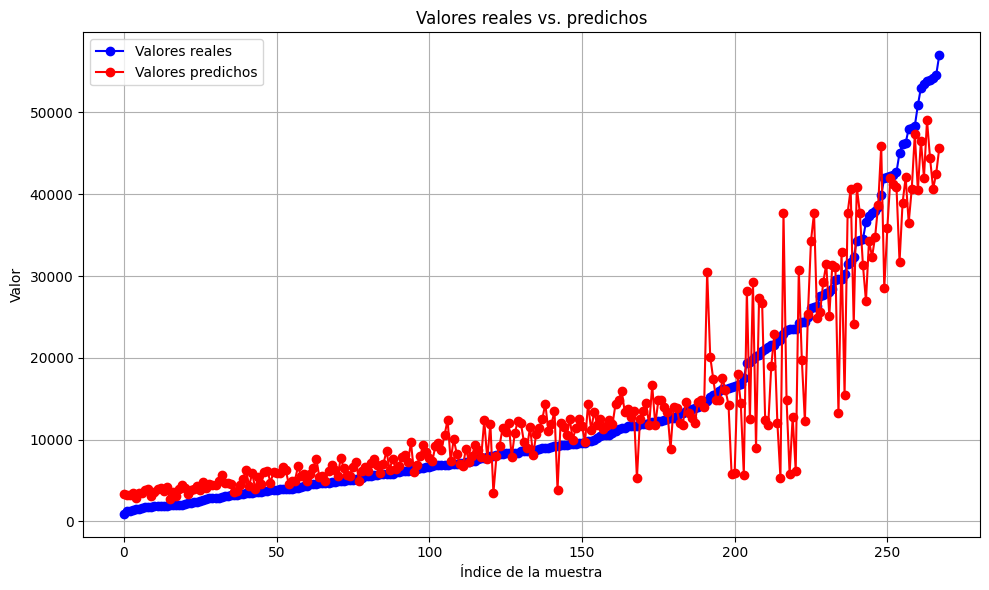

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, learning_curve
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_squared_log_error
from catboost import CatBoostRegressor
from math import sqrt

# Supongamos que la función load_split está definida y carga los datos correctamente
X_train, X_test, y_train, y_test = load_split(0)

# Convertir y_train e y_test a series de pandas para asegurar que no haya problemas de tipo
y_train = y_train.squeeze().astype(float)
y_test = y_test.squeeze().astype(float)

# Codificar las variables categóricas después de cargar la división con OneHotEncoder
categorical_features = ['Sexo', 'Fumador', 'Region EEUU']
numeric_features = X_train.select_dtypes(include=[np.number]).columns.tolist()
numeric_features = [col for col in numeric_features if col not in categorical_features]

# Pipeline para preprocesamiento
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

# Aplicar el preprocesador a los datos de entrenamiento y prueba
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

# CatBoost Regression
# Iniciamos el modelo
model = CatBoostRegressor(random_state=42, silent=True)

# Ajustamos el modelo a los datos
model.fit(X_train, y_train)

# Realizamos la validación cruzada con 10-fold
scores = cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', cv=10)
print(f"Cross-validated MSE: {-np.mean(scores)}")

# Optimización de los Hiperparámetros
# Definimos los valores para iterar y elegir los mejores parámetros
param_grid = {
    'iterations': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'depth': [3, 4, 5]
}

# Iniciamos la búsqueda de hiperparámetros
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=10, scoring='neg_mean_squared_error', n_jobs=1, verbose=1)

# Ajustamos a los datos de entrenamiento
grid_search.fit(X_train, y_train)

# Obtenemos los mejores parámetros
best_params = grid_search.best_params_
print("Best parameters:", best_params)

# Actualizamos el modelo con los parámetros encontrados
model = grid_search.best_estimator_

# Características más importantes
# Obtenemos la importancia de cada variable
importances = model.feature_importances_

# Crear un DataFrame con las importancias de las características
feature_names = preprocessor.transformers_[0][2] + preprocessor.transformers_[1][1].get_feature_names_out(categorical_features).tolist()
feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Ordenamos por importancia
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Seleccionamos la misma paleta de colores utilizada anteriormente
n_colores = len(feature_importances)
colores = sns.color_palette('viridis', n_colors=n_colores)

# Graficamos las características y su importancia
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances, palette=colores)
plt.title('Importancia de las Características')
plt.xlabel('Importancia')
plt.ylabel('Características')
plt.show()

# Realizamos las predicciones
y_pred = model.predict(X_test)

# Asegurarnos de que y_test y y_pred sean del tipo float
y_test = y_test.astype(float)
y_pred = y_pred.astype(float)

# Gráfico de dispersión de los valores reales vs. predichos
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot(np.linspace(min(y_test), max(y_test), 100), np.linspace(min(y_test), max(y_test), 100), color='red', linestyle='--', linewidth=2)
plt.xlabel("Valores Reales")
plt.ylabel("Predicciones")
plt.title("Valores Reales vs. Predicciones")
plt.grid(True)
plt.tight_layout()
plt.show()

# Calcular MAE, MSE, RMSE, R2
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R2 Score:", r2)

# Calcular RMSLE (Root Mean Squared Logarithmic Error)
if (y_test >= 0).all() and (y_pred >= 0).all():
    rmsle = np.sqrt(mean_squared_log_error(y_test, y_pred))
    print("RMSLE:", rmsle)
else:
    print("RMSLE: cannot be calculated because some values are negative")

# Calcular MAPE (Mean Absolute Percentage Error)
def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape_score = mape(y_test, y_pred)
print("MAPE:", mape_score)

# Graficar la curva de aprendizaje (learning curve)
train_sizes, train_scores, test_scores = learning_curve(model, X_train, y_train, cv=10)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', color='r', label='Training score')
plt.plot(train_sizes, np.mean(test_scores, axis=1), 'o-', color='g', label='Cross-validation score')
plt.title('Learning Curves')
plt.xlabel('Training examples')
plt.ylabel('Score')
plt.legend(loc='best')
plt.grid()
plt.show()

# Gráfico de línea de los valores reales vs. predichos
plt.figure(figsize=(10, 6))
plt.plot(y_test, label="Valores reales")
plt.plot(y_pred, label="Valores predichos")
plt.xlabel("Índice de la muestra")
plt.ylabel("Valor")
plt.title("Valores reales vs. predichos")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Crear un array con el índice de las muestras
indices = np.arange(len(y_test))

# Ordenar los valores reales y predichos por los valores reales
sorted_indices = np.argsort(y_test)

# Graficar los valores reales y predichos
plt.figure(figsize=(10, 6))
plt.plot(indices, y_test[sorted_indices], 'b-', marker='o', label='Valores reales')
plt.plot(indices, y_pred[sorted_indices], 'r-', marker='o', label='Valores predichos')
plt.xlabel('Índice de la muestra')
plt.ylabel('Valor')
plt.title('Valores reales vs. predichos')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
